# Weighted Least Squares

FUNCIONA PERFECTAMENTE

In [1]:
%matplotlib inline

from __future__ import print_function
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)
np.random.seed(1024)

## WLS Estimation

### Artificial data: Heteroscedasticity 2 groups 

Model assumptions:

 * Misspecification: true model is quadratic, estimate only linear
 * Independent noise/error term
 * Two groups for error variance, low and high variance groups

In [2]:
nsample = 50
x = np.linspace(0, 20, nsample)
X = np.column_stack((x, (x - 5)**2))
X = sm.add_constant(X)
beta = [5., 0.5, -0.01]
sig = 0.5
w = np.ones(nsample)
w[nsample * 6//10:] = 3
y_true = np.dot(X, beta)
e = np.random.normal(size=nsample)
y = y_true + sig * w * e 
X = X[:,[0,1]]

### WLS knowing the true variance ratio of heteroscedasticity

In [3]:
mod_wls = sm.WLS(y, X, weights=1./w)
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.910
Model:                            WLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     487.9
Date:                Thu, 31 Mar 2016   Prob (F-statistic):           8.52e-27
Time:                        22:09:10   Log-Likelihood:                -57.048
No. Observations:                  50   AIC:                             118.1
Df Residuals:                      48   BIC:                             121.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.2726      0.185     28.488      0.0

## OLS vs. WLS

Estimate an OLS model for comparison: 

In [4]:
res_ols = sm.OLS(y, X).fit()
print(res_ols.params)
print(res_wls.params)

[ 5.24256099  0.43486879]
[ 5.27260714  0.43794441]


Compare the WLS standard errors to  heteroscedasticity corrected OLS standard errors:

In [5]:
se = np.vstack([[res_wls.bse], [res_ols.bse], [res_ols.HC0_se], 
                [res_ols.HC1_se], [res_ols.HC2_se], [res_ols.HC3_se]])
se = np.round(se,4)
colnames = ['x1', 'const']
rownames = ['WLS', 'OLS', 'OLS_HC0', 'OLS_HC1', 'OLS_HC3', 'OLS_HC3']
tabl = SimpleTable(se, colnames, rownames, txt_fmt=default_txt_fmt)
print(tabl)

          x1   const 
---------------------
WLS     0.1851 0.0198
OLS     0.2707 0.0233
OLS_HC0 0.194  0.0281
OLS_HC1 0.198  0.0287
OLS_HC3 0.2003 0.029 
OLS_HC3 0.207   0.03 
---------------------


Calculate OLS prediction interval:

In [6]:
covb = res_ols.cov_params()
prediction_var = res_ols.mse_resid + (X * np.dot(covb,X.T).T).sum(1)
prediction_std = np.sqrt(prediction_var)
tppf = stats.t.ppf(0.975, res_ols.df_resid)

In [7]:
prstd_ols, iv_l_ols, iv_u_ols = wls_prediction_std(res_ols)

Draw a plot to compare predicted values in WLS and OLS:

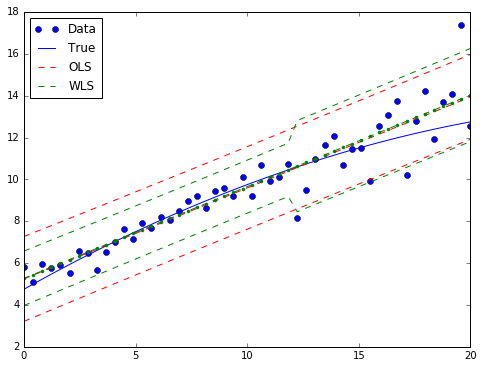

In [8]:
prstd, iv_l, iv_u = wls_prediction_std(res_wls)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y, 'o', label="Data")
ax.plot(x, y_true, 'b-', label="True")
# OLS
ax.plot(x, res_ols.fittedvalues, 'r--')
ax.plot(x, iv_u_ols, 'r--', label="OLS")
ax.plot(x, iv_l_ols, 'r--')
# WLS
ax.plot(x, res_wls.fittedvalues, 'g--.')
ax.plot(x, iv_u, 'g--', label="WLS")
ax.plot(x, iv_l, 'g--')
ax.legend(loc="best");

## Feasible Weighted Least Squares (2-stage FWLS)

In [9]:
resid1 = res_ols.resid[w==1.]
var1 = resid1.var(ddof=int(res_ols.df_model)+1)
resid2 = res_ols.resid[w!=1.]
var2 = resid2.var(ddof=int(res_ols.df_model)+1)
w_est = w.copy()
w_est[w!=1.] = np.sqrt(var2) / np.sqrt(var1)
res_fwls = sm.WLS(y, X, 1./w_est).fit()
print(res_fwls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.914
Model:                            WLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     507.1
Date:                Thu, 31 Mar 2016   Prob (F-statistic):           3.65e-27
Time:                        22:09:59   Log-Likelihood:                -55.777
No. Observations:                  50   AIC:                             115.6
Df Residuals:                      48   BIC:                             119.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.2710      0.177     29.828      0.0